This project analyzes gun violence data from 2013-2018 provided at Kaggle (https://www.kaggle.com/jameslko/gun-violence-data). The goal is to predict and characterize socioeconomic conditions surrounding a gun violence incident using census data pulled from tables at census.gov (https://data.census.gov/cedsci/table?q=).

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import time
import re
import os

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 109)
pd.set_option('display.max_rows', 109)

The below cell runs the pre-processing steps which include dropping unused columns, rows with missing values, parsing multi-value columns, simplifying and reducing incident characteristics, and binning multi-value columns. There also exists snippets used to scrape for census data and shapefiles. It exposes the cleaned pandas dataframe under the alias 'data'.

In [22]:
from data import *
data

,date,state,n_killed,n_injured,congressional_district,incident_characteristics,latitude,longitude,participant_age,participant_type,Male,Female,Unlawful Possession of Gun,School Incident,Defensive Use,Gun(s) Involved with Other Crimes,Concealed Carry Incident,Drive-by,Non-Aggression Incident,Drug/Alcohol Involvement,Officer Involved Incident,Gang involvement,BB/Pellet/Replica gun
0,2013-01-01,Ohio,1,3,09,"{Regular Shooting, Drug/Alcohol Involvement}",41.4455,-82.1377,"{0: ['25'], 1: ['31'], 2: ['33'], 3: ['34'], 4...","{0: ['Subject-Suspect'], 1: ['Subject-Suspect'...",5,0,False,False,False,False,False,False,False,True,False,False,False
1,2013-01-05,Colorado,4,0,06,"{Regular Shooting, Drug/Alcohol Involvement, G...",39.6518,-104.8020,"{0: ['29'], 1: ['33'], 2: ['56'], 3: ['33']}","{0: ['Victim'], 1: ['Victim'], 2: ['Victim'], ...",3,1,False,False,False,True,False,False,False,True,True,False,False
2,2013-01-07,North Carolina,2,2,06,"{Murder/Suicide, Gun(s) Involved with Other Cr...",36.1140,-79.9569,"{0: ['18'], 1: ['46'], 2: ['14'], 3: ['47']}","{0: ['Victim'], 1: ['Victim'], 2: ['Victim'], ...",2,2,False,False,False,True,False,False,False,False,False,False,False
3,2013-01-19,New Mexico,5,0,01,"{Gun(s) Involved with Other Crimes, Mass/Spree...",34.9791,-106.7160,"{0: ['51'], 1: ['40'], 2: ['9'], 3: ['5'], 4: ...","{0: ['Victim'], 1: ['Victim'], 2: ['Victim'], ...",3,3,False,False,False,True,False,False,False,False,False,False,False
4,2013-01-26,Ohio,1,3,08,"{Mass/Spree Shooting, Drug/Alcohol Involvement}",39.9252,-83.8218,"{0: ['34'], 1: ['28'], 2: ['23'], 3: ['29'], 4...","{0: ['Victim'], 1: ['Victim'], 2: ['Victim'], ...",5,0,False,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99861,2018-03-31,Tennessee,0,1,09,"{Gun(s) Involved with Other Crimes, Regular Sh...",35.2045,-89.9872,"{0: ['69'], 1: ['35']}","{0: ['Victim'], 1: ['Subject-Suspect']}",1,1,False,False,False,True,False,False,False,False,False,False,False
99862,2018-03-31,Washington,0,0,05,"{Gun(s) Involved with Other Crimes, Non-Shooti...",47.6638,-117.2350,{0: ['48']},{0: ['Subject-Suspect']},1,0,False,False,False,True,False,False,False,False,False,False,False
99863,2018-03-31,Louisiana,0,1,02,{Regular Shooting},29.9239,-90.0442,{0: ['21']},{0: ['Victim']},1,0,False,False,False,False,False,False,False,False,False,False,False
99864,2018-03-31,Texas,1,0,09,{Regular Shooting},29.7201,-95.6110,{0: ['42']},{0: ['Victim']},1,0,False,False,False,False,False,False,False,False,False,False,False


The next few cells generate my target vector. Only incidentents in Illinois were analyzed to limit the scope of this project to something manageable. Unemployment rates were chosen as my response variable under the thought that gun violence could have ties to financial and job stability. I look at the unemployment rate of every congressional district within the state over the course of a single year for the entire population.

In [4]:
def get_target(x):
    year = x.date.year
    state = '17'
    district = x.congressional_district
    
    file = '/home/toffer/GradSchool/DataMiningI/FinalProject/CensusData/{}/{}/{}.csv'
    lines = []
    with open(file.format(year, state, district)) as fp:
        for cnt, line in enumerate(fp):
            lines.append(line)

    setup = []
    for line in lines:
        temp = re.findall('"([^"]*)"', line)
        temp = [i for i in temp if i]
        temp = temp[len(temp)-8:]
        if len(temp) == 8:
            setup.append(temp)

    setup = np.array(setup)

    rows = ['Population 16 years and over', '16 to 19 years', '20 to 24 years','25 to 44 years',
            '45 to 54 years','55 to 64 years','65 to 74 years','75 years and over', 'One race', 'White', 'Black or African American', 
            'American Indian and Alaska Native', 'Asian', 'Native Hawaiian and Other Pacific Islander', 
            'Some other race', 'Two or more races', 'Hispanic or Latino origin (of any race)', 
            'White alone, not Hispanic or Latino', 'Population 20 to 64 years', 'Male', 'Female',
            'With own children under 6 years','Below poverty level','With any disability','Population 25 to 64 years',
            'Less than high school graduate','High school graduate (includes equivalency)',
            'Some college or associates degree','Bachelors degree or higher','Employment status for population 16 years and over',]
    cols = ['Total - Estimate', 'Total - Margin of Error', 'In Labor Force - Estimate', 'In labor force - Margin of Error',
           'Employed - Estimate', 'Employed - Margin of Error', 'Unemployment rate - Estimate', 'Unemployment - Margin of error']

    df = pd.DataFrame(setup, columns=cols)
    top_row = pd.DataFrame(cols)
    df = df.iloc[1:]
    df = df.reset_index(drop=True)
    df['labels'] = pd.Series(rows)
    return float(df['Unemployment rate - Estimate'][0][:-1])

target = data[data.state == 'Illinois'].apply(get_target, axis=1)
target = pd.concat([target, data[data.state == 'Illinois'].date], axis=1)
target = target.reset_index(drop=True)

After extracting unemployment rates for each year, quantile thresholds are calculated.

In [3]:
def get_thresh(year):
    file = '/home/toffer/GradSchool/DataMiningI/FinalProject/CensusData/{}/17/{}.csv'
    rates = []
    for i in range(18):
        lines = []
        district = str(i+1).zfill(2)
        with open(file.format(year, district)) as fp:
            for cnt, line in enumerate(fp):
                lines.append(line)

        setup = []
        for line in lines:
            temp = re.findall('"([^"]*)"', line)
            temp = [i for i in temp if i]
            temp = temp[len(temp)-8:]
            if len(temp) == 8:
                setup.append(temp)

        setup = np.array(setup)

        rows = ['Population 16 years and over', '16 to 19 years', '20 to 24 years','25 to 44 years',
                '45 to 54 years','55 to 64 years','65 to 74 years','75 years and over', 'One race', 'White', 'Black or African American', 
                'American Indian and Alaska Native', 'Asian', 'Native Hawaiian and Other Pacific Islander', 
                'Some other race', 'Two or more races', 'Hispanic or Latino origin (of any race)', 
                'White alone, not Hispanic or Latino', 'Population 20 to 64 years', 'Male', 'Female',
                'With own children under 6 years','Below poverty level','With any disability','Population 25 to 64 years',
                'Less than high school graduate','High school graduate (includes equivalency)',
                'Some college or associates degree','Bachelors degree or higher','Employment status for population 16 years and over',]
        cols = ['Total - Estimate', 'Total - Margin of Error', 'In Labor Force - Estimate', 'In labor force - Margin of Error',
               'Employed - Estimate', 'Employed - Margin of Error', 'Unemployment rate - Estimate', 'Unemployment - Margin of error']

        df = pd.DataFrame(setup, columns=cols)
        top_row = pd.DataFrame(cols)
        df = df.iloc[1:]
        df = df.reset_index(drop=True)
        df['labels'] = pd.Series(rows)
        rates.append(df['Unemployment rate - Estimate'][0])
    rates = [float(rate[:-1]) for rate in rates]
    quantiles = [i for i in range(25, 100, 25)]
    return [np.percentile(rates,x) for x in quantiles]

thresholds = {year:get_thresh(year) for year in range(2013, 2019)}
thresholds

{2013: [7.7250000000000005, 8.899999999999999, 10.25],
 2014: [6.325, 7.6, 8.625],
 2015: [5.324999999999999, 6.0, 7.700000000000001],
 2016: [5.0, 5.6, 7.1000000000000005],
 2017: [4.45, 5.35, 6.375000000000001],
 2018: [3.9499999999999997, 5.05, 6.325000000000001]}

From here, each rate assosciated with a particular gun violence incident was binned into the appropriate quantile, taking into account the year in which the incident occured. This acts as a measure of how severe unemployment was surrounding the incident compared to the rest of the state.

In [5]:
def get_quantile(x):
    for i, thresh in enumerate(thresholds[x.date.year]):
        if x[0] < thresh:
            return i
    return len(thresholds[x.date.year])

target = target.apply(get_quantile, axis=1)

In [6]:
classes = [i for i in range(len(thresholds[2013])+1)]

After generating my target vector, I procede to finalizing my design matrix. I drop any data corresponding to location and time, as these features were used in the creation of my target vector. By removing them, I make sure the model learns the correlations between incident characteristics and unemployment rates instead of finding the connections between locations and their unemployment rates.

Eventually I would like to re-incoorporate data about the participants age and type. The goal would be to generate my target vector by extracting the unemployment rate of the age group the shooter was associated with. Also, I want to get more relevent census data by looking at smaller regions than congressional districts by associating the incident's longitude and latitude coordinates to a particular county using shapefiles. I had made some progress on this front, but after some time calculations I realized the steps I had setup to combine all this data would take longer than what I had available.

In [7]:
design = data.drop([
    'date', 
    'state', 
    'congressional_district', 
    'participant_age',
    'participant_type',
    'incident_characteristics',
    'latitude',
    'longitude'
], axis=1)
design = design[data.state == 'Illinois']
design = design.reset_index(drop=True)

In [8]:
design

,n_killed,n_injured,Male,Female,Unlawful Possession of Gun,School Incident,Defensive Use,Gun(s) Involved with Other Crimes,Concealed Carry Incident,Drive-by,Non-Aggression Incident,Drug/Alcohol Involvement,Officer Involved Incident,Gang involvement,BB/Pellet/Replica gun
0,1,3,4,1,False,False,False,False,False,False,False,False,False,False,False
1,1,4,3,2,False,False,False,False,False,True,False,False,False,False,False
2,0,6,3,3,False,False,False,False,False,True,False,False,False,False,False
3,0,5,5,1,False,False,True,False,False,False,False,False,False,False,False
4,1,3,1,3,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9367,0,2,1,1,False,False,False,False,False,False,False,False,False,False,False
9368,0,0,1,0,True,False,False,True,False,False,False,False,False,False,False
9369,1,1,1,0,False,False,False,False,False,False,False,False,False,False,False
9370,1,0,1,0,False,False,False,True,False,False,False,False,True,False,False


After finalizing my design matrix and target vector, I explored my class frequencies and soon realized there is a class imbalance issue within my data. To solve this, I tried 3 different techniques before fitting my model: random undersampling, random oversampling, and SMOTETomek which combines both undersampling and oversampling.

The three supervised classifiers choosen for this analysis were random forests, naive Bayes and K-Nearest Neighbors. Before fitting each model a grid search was ran to identify the best set of hyperparameter values within the search space. For random forests the following hyperparameters were tuned: number of estimators, max depth, min number of samples per leaf, and the splitting criterion. Naive Bayes tuning was performed on the alpha smoothing parameter. Finally, KNN was tuned for the number of neighbors.

After hyperparameter tuning was complete, the models were fit and run through k-folds cross-validation for K=10. Predictions were then made on the test set and confusion matrices displayed to visualize model performance.

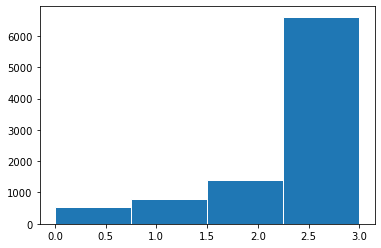

In [9]:
plt.hist(target.values, bins=len(thresholds[2013])+1, edgecolor='white', linewidth=1)
plt.show()

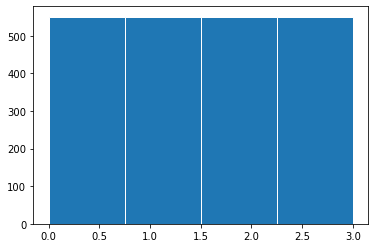

In [10]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='auto',random_state=42)
design_s, target_s = rus.fit_resample(design.values, target.values)

plt.hist(target_s, bins=len(thresholds[2013])+1, edgecolor='white', linewidth=1)
plt.show()

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
0.3257918552036199


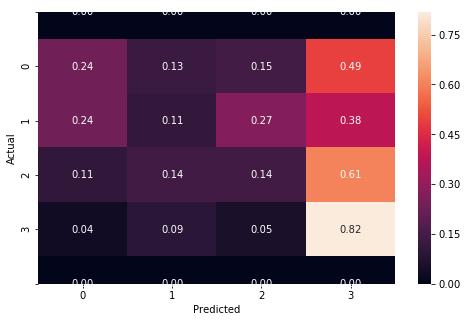

0.3076923076923077


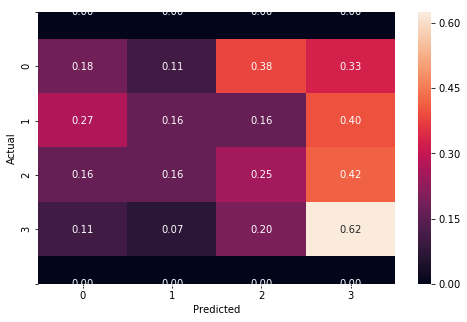

0.3438914027149321


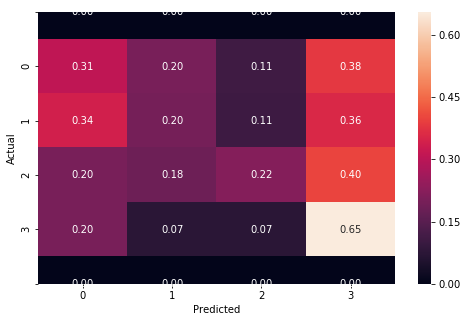

0.3574660633484163


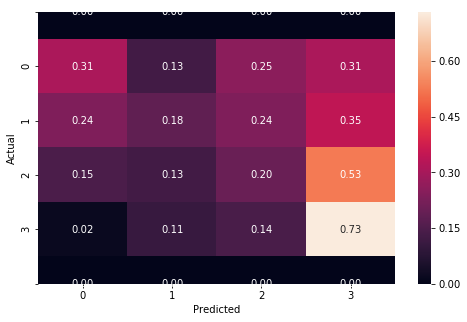

0.3393665158371041


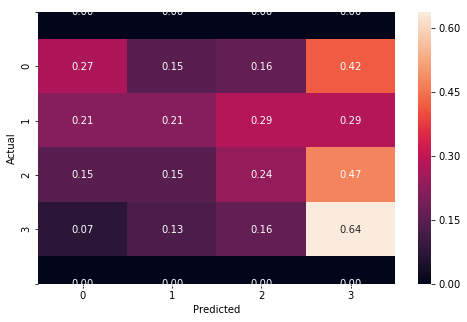

0.38461538461538464


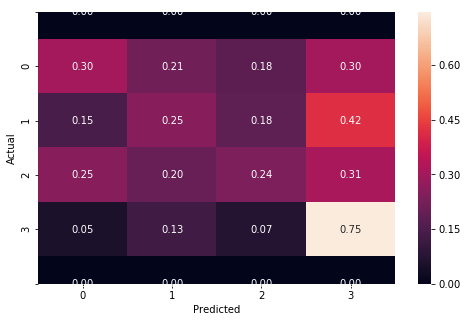

0.3076923076923077


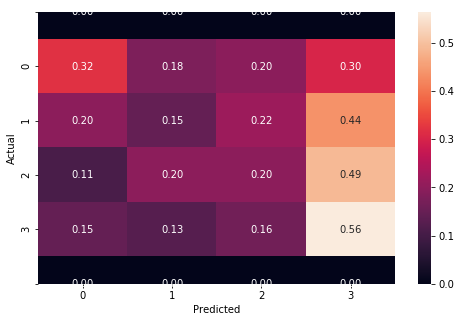

0.3393665158371041


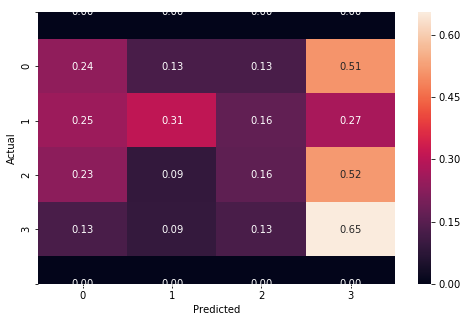

0.3755656108597285


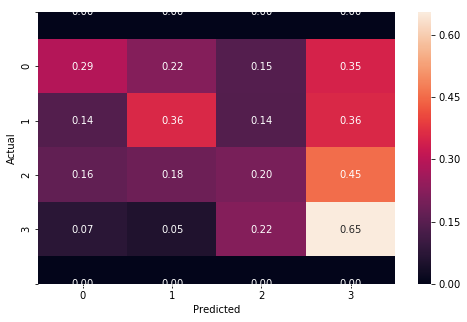

0.3076923076923077


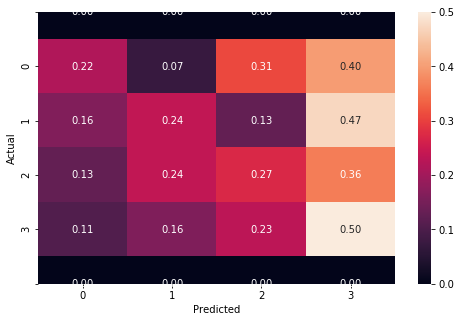

In [11]:
# Random Forest
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.10, random_state=42)
sss.get_n_splits(design.values,target.values)

parameters={'criterion':['gini','entropy'],
            'n_estimators':[i for i in range(10,50,10)],
            'max_depth':[i for i in range(8,20,2)],
            'min_samples_leaf':[i for i in range(5,30,5)]}

rf = RandomForestClassifier(random_state=42)

clf=GridSearchCV(rf,parameters)  
clf.fit(design_s,target_s)
print(clf.best_estimator_.get_params())

for train_index, test_index in sss.split(design_s, target_s):
    X_train, X_test = design_s[train_index], design_s[test_index]
    y_train, y_test = target_s[train_index], target_s[test_index]
    clf.best_estimator_.fit(X_train,y_train)
    y_pred=clf.best_estimator_.predict(X_test)
    print('Score: '+clf.best_estimator_.score(X_test,y_test))
    
    conf=confusion_matrix(y_test, y_pred, classes)
    c = conf/conf.astype(np.float).sum(axis=1)[:, np.newaxis]
    dummy_row=np.zeros((len(thresholds[2013])+1,))
    c = np.vstack([dummy_row,c,dummy_row])
    fig, ax = plt.subplots(figsize=(8,5))
    sns.heatmap(c, annot=True, fmt='.2f', xticklabels=classes, yticklabels=['']+classes+[''])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

{'alpha': 10, 'binarize': 0.0, 'class_prior': None, 'fit_prior': True}
0.2986425339366516


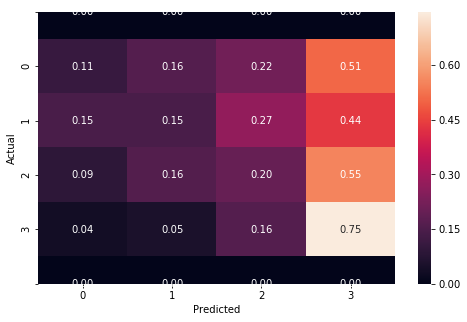

0.334841628959276


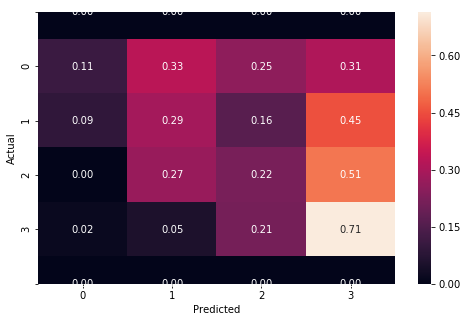

0.3438914027149321


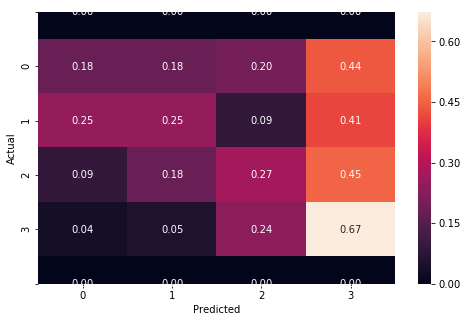

0.3574660633484163


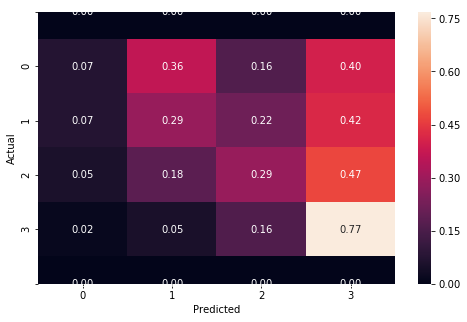

0.3257918552036199


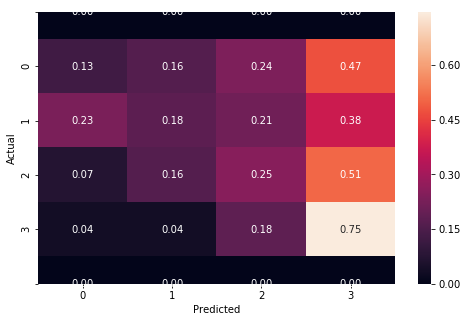

0.31221719457013575


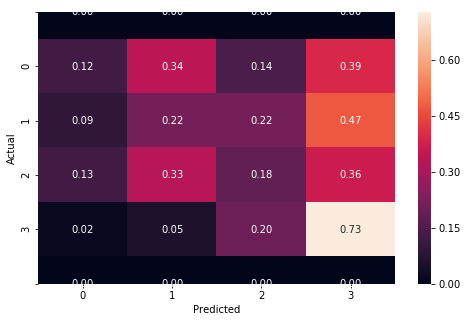

0.2850678733031674


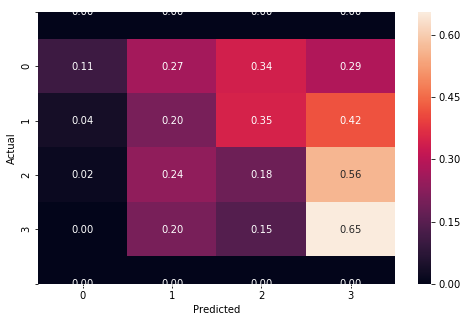

0.3212669683257919


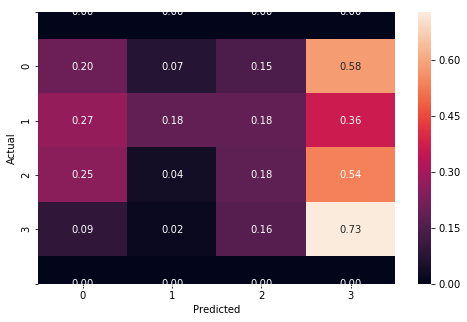

0.3212669683257919


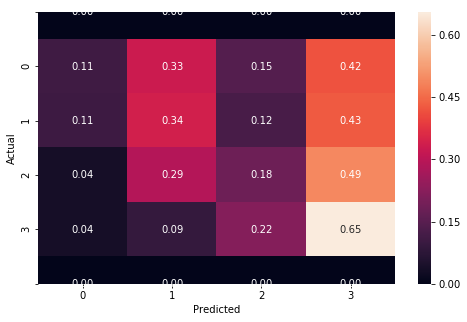

0.28054298642533937


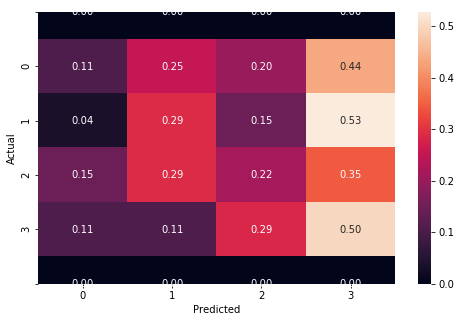

In [12]:
# Naive Bayes
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.10, random_state=42)
sss.get_n_splits(design.values,target.values)

parameters={'alpha':[i for i in range(10,len(design),100)]}
clf=GridSearchCV(bnb,parameters)  
clf.fit(design_s,target_s)
print(clf.best_estimator_.get_params())

for train_index, test_index in sss.split(design_s, target_s):
    X_train, X_test = design_s[train_index], design_s[test_index]
    y_train, y_test = target_s[train_index], target_s[test_index]
  
    clf.best_estimator_.fit(X_train,y_train)
    y_pred=clf.best_estimator_.predict(X_test)
    print('Score: '+clf.best_estimator_.score(X_test,y_test))
    
    conf=confusion_matrix(y_test, y_pred, classes)
    c = conf/conf.astype(np.float).sum(axis=1)[:, np.newaxis]
    dummy_row=np.zeros((len(thresholds[2013])+1,))
    c = np.vstack([dummy_row,c,dummy_row])
    fig, ax = plt.subplots(figsize=(8,5))
    sns.heatmap(c, annot=True, fmt='.2f', xticklabels=classes, yticklabels=['']+classes+[''])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
0.3574660633484163


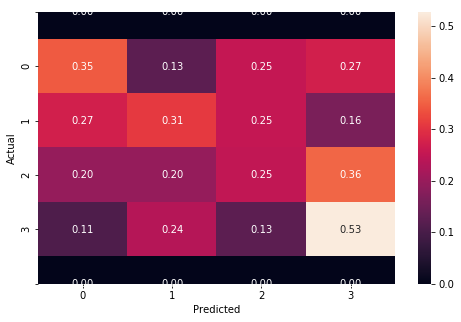

0.3076923076923077


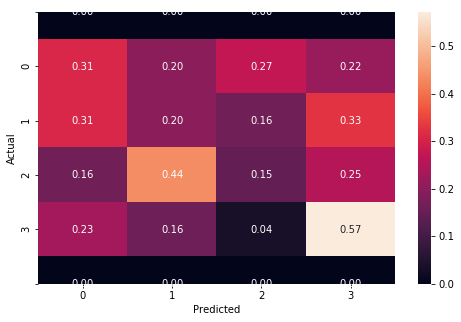

0.2895927601809955


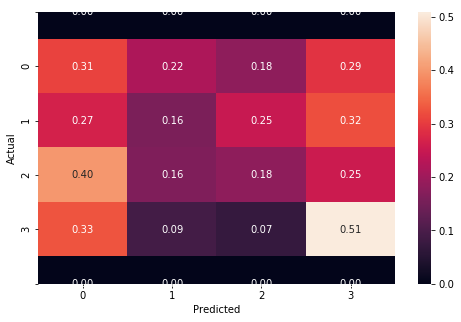

0.2895927601809955


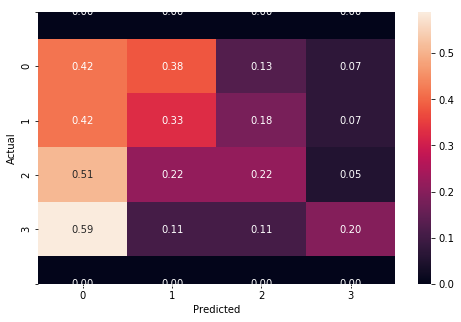

0.2850678733031674


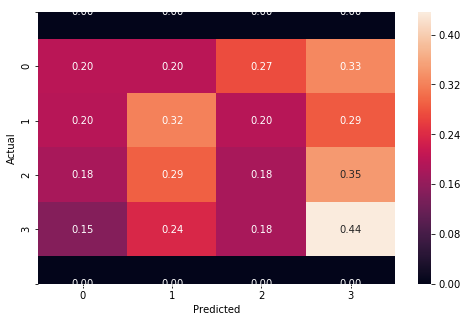

0.31221719457013575


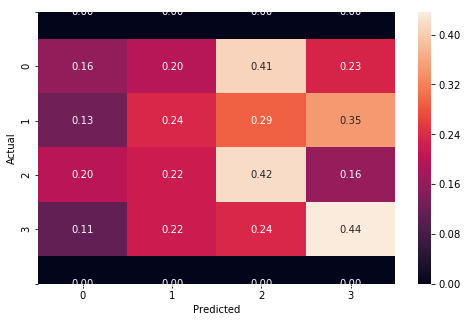

0.27601809954751133


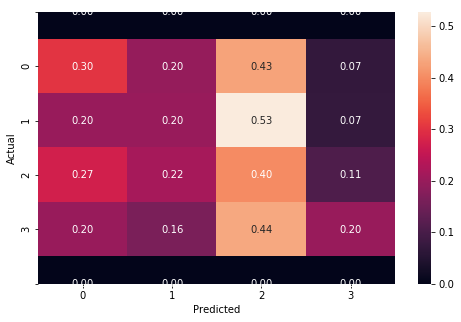

0.2850678733031674


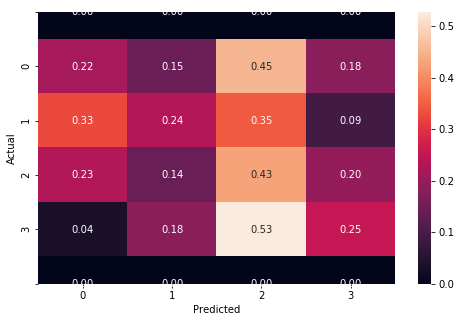

0.35294117647058826


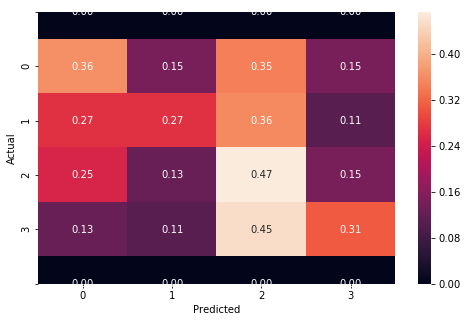

0.248868778280543


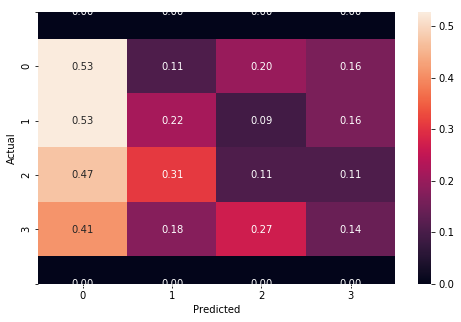

In [13]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.10, random_state=42)
sss.get_n_splits(design.values,target.values)

neigh = KNeighborsClassifier()

parameters={'n_neighbors':[i for i in range(5,10,1)]}
clf=GridSearchCV(neigh,parameters)  
clf.fit(design_s,target_s)
print(clf.best_estimator_.get_params())

for train_index, test_index in sss.split(design_s, target_s):
    X_train, X_test = design_s[train_index], design_s[test_index]
    y_train, y_test = target_s[train_index], target_s[test_index]
  
    clf.best_estimator_.fit(X_train,y_train)
    y_pred=clf.best_estimator_.predict(X_test)
    print('Score: '+clf.best_estimator_.score(X_test,y_test))
    
    conf=confusion_matrix(y_test, y_pred, classes)
    c = conf/conf.astype(np.float).sum(axis=1)[:, np.newaxis]
    dummy_row=np.zeros((len(thresholds[2013])+1,))
    c = np.vstack([dummy_row,c,dummy_row])
    fig, ax = plt.subplots(figsize=(8,5))
    sns.heatmap(c, annot=True, fmt='.2f', xticklabels=classes, yticklabels=['']+classes+[''])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

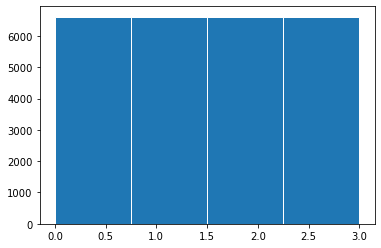

In [14]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
design_s, target_s = ros.fit_resample(design.values, target.values)

plt.hist(target_s, bins=len(thresholds[2013])+1, edgecolor='white', linewidth=1)
plt.show()

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 18, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 40, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
0.43348450491307633


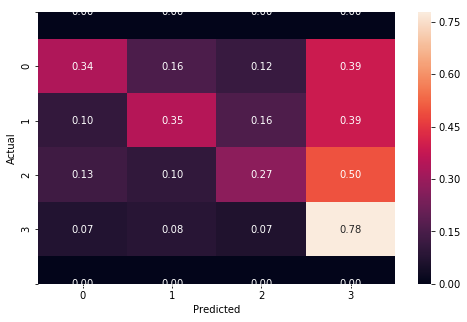

0.4327286470143613


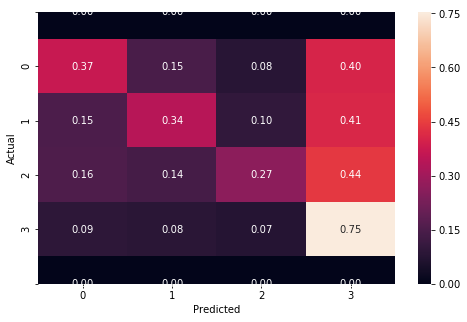

0.4467120181405896


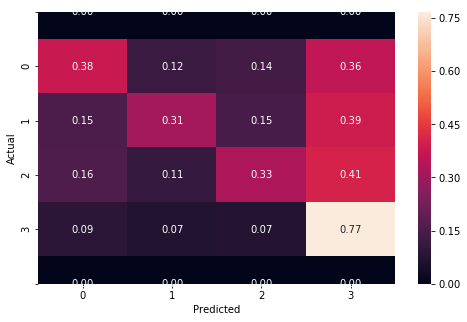

0.4489795918367347


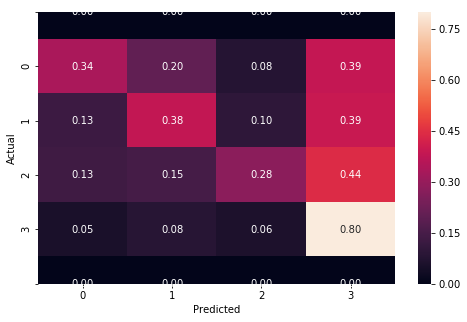

0.41685563114134544


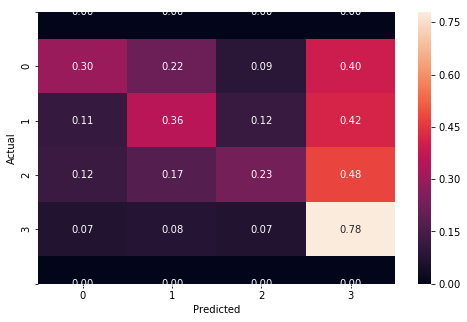

0.42781557067271353


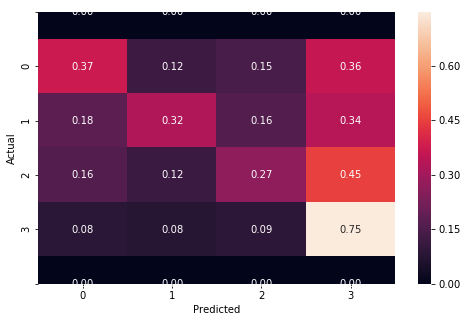

0.4440665154950869


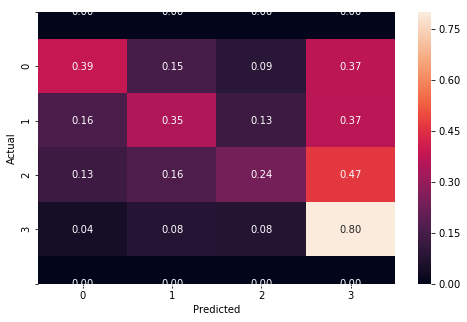

0.4618291761148904


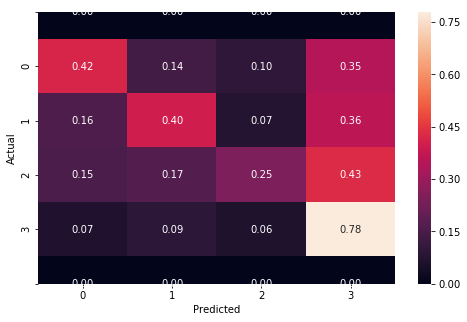

0.4467120181405896


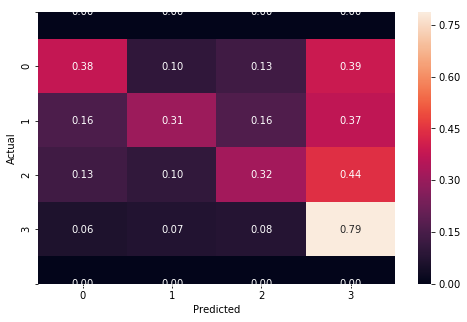

0.4410430839002268


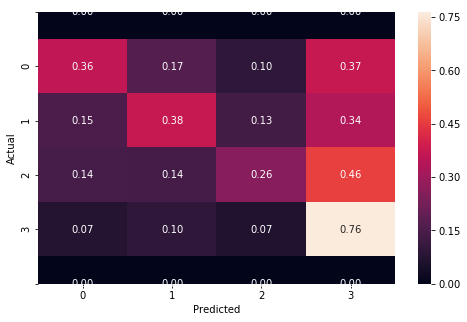

In [15]:
# Random Forest
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.10, random_state=42)
sss.get_n_splits(design.values,target.values)

parameters={'criterion':['gini','entropy'],
            'n_estimators':[i for i in range(10,50,10)],
            'max_depth':[i for i in range(8,20,2)],
            'min_samples_leaf':[i for i in range(5,30,5)]}

rf = RandomForestClassifier(random_state=42)

clf=GridSearchCV(rf,parameters)  
clf.fit(design_s,target_s)
print(clf.best_estimator_.get_params())

for train_index, test_index in sss.split(design_s, target_s):
    X_train, X_test = design_s[train_index], design_s[test_index]
    y_train, y_test = target_s[train_index], target_s[test_index]
    clf.best_estimator_.fit(X_train,y_train)
    y_pred=clf.best_estimator_.predict(X_test)
    print('Score: '+clf.best_estimator_.score(X_test,y_test))
    
    conf=confusion_matrix(y_test, y_pred, classes)
    c = conf/conf.astype(np.float).sum(axis=1)[:, np.newaxis]
    dummy_row=np.zeros((len(thresholds[2013])+1,))
    c = np.vstack([dummy_row,c,dummy_row])
    fig, ax = plt.subplots(figsize=(8,5))
    sns.heatmap(c, annot=True, fmt='.2f', xticklabels=classes, yticklabels=['']+classes+[''])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

{'alpha': 10, 'binarize': 0.0, 'class_prior': None, 'fit_prior': True}
0.3507180650037793


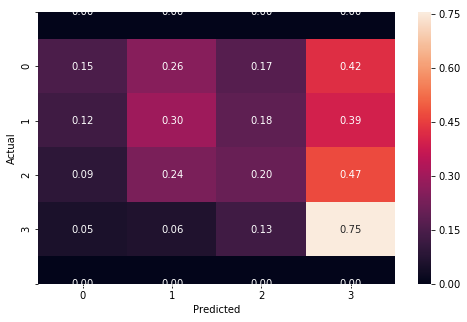

0.3352229780801209


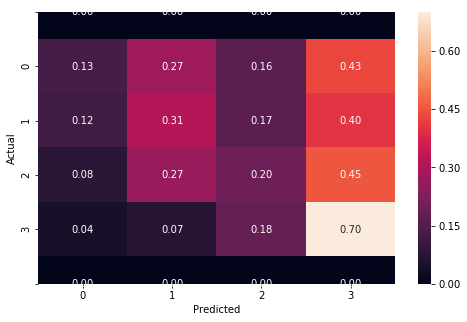

0.3492063492063492


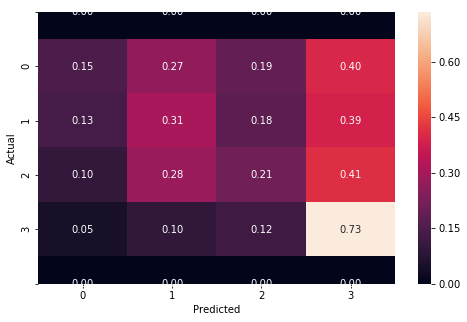

0.3458049886621315


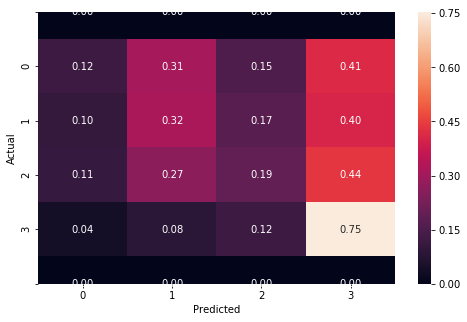

0.34996220710506426


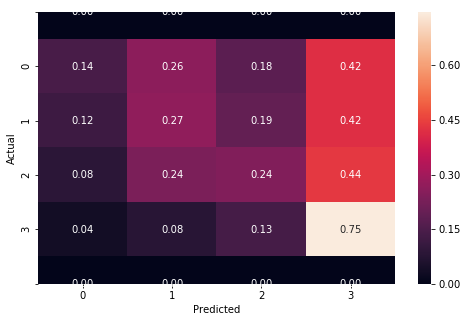

0.36772486772486773


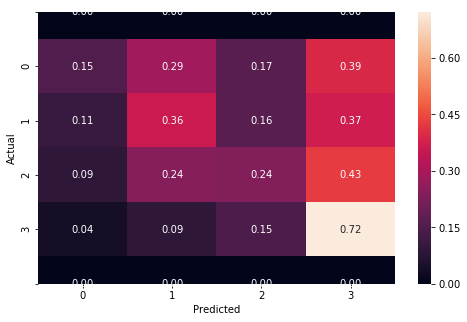

0.35752078609221466


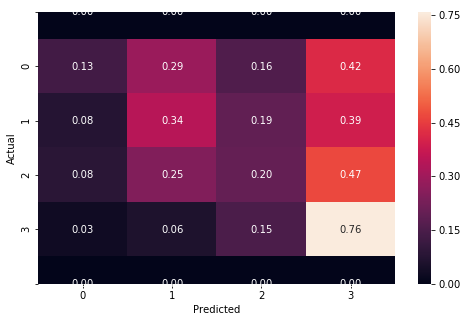

0.34996220710506426


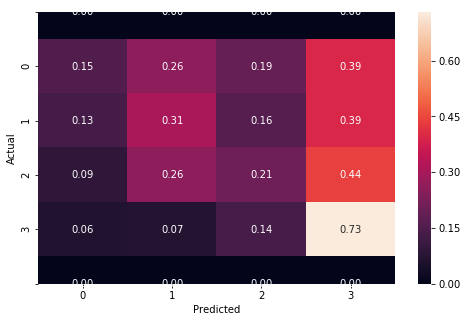

0.35411942554799697


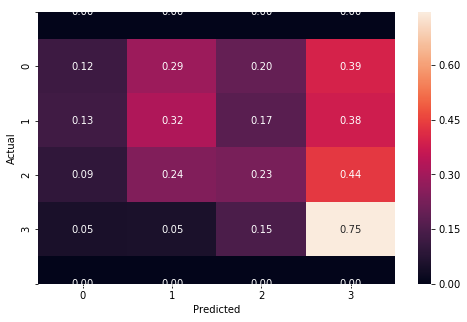

0.36092214663643235


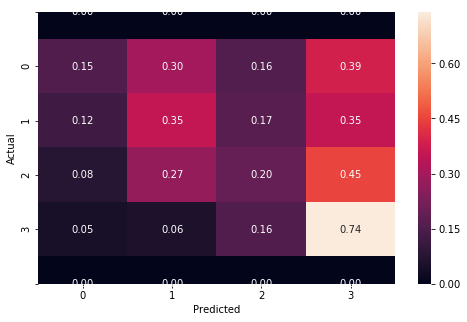

In [16]:
# Naive Bayes
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.10, random_state=42)
sss.get_n_splits(design.values,target.values)

parameters={'alpha':[i for i in range(10,len(design),100)]}
clf=GridSearchCV(bnb,parameters)  
clf.fit(design_s,target_s)
print(clf.best_estimator_.get_params())

for train_index, test_index in sss.split(design_s, target_s):
    X_train, X_test = design_s[train_index], design_s[test_index]
    y_train, y_test = target_s[train_index], target_s[test_index]
  
    clf.best_estimator_.fit(X_train,y_train)
    y_pred=clf.best_estimator_.predict(X_test)
    print('Score: '+clf.best_estimator_.score(X_test,y_test))
    
    conf=confusion_matrix(y_test, y_pred, classes)
    c = conf/conf.astype(np.float).sum(axis=1)[:, np.newaxis]
    dummy_row=np.zeros((len(thresholds[2013])+1,))
    c = np.vstack([dummy_row,c,dummy_row])
    fig, ax = plt.subplots(figsize=(8,5))
    sns.heatmap(c, annot=True, fmt='.2f', xticklabels=classes, yticklabels=['']+classes+[''])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.36507936507936506


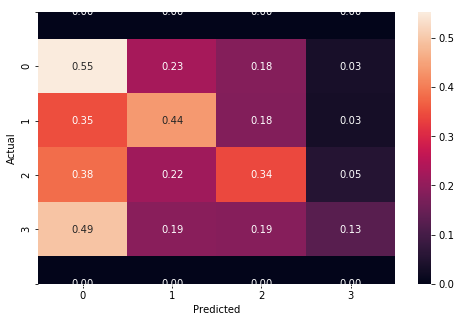

0.35827664399092973


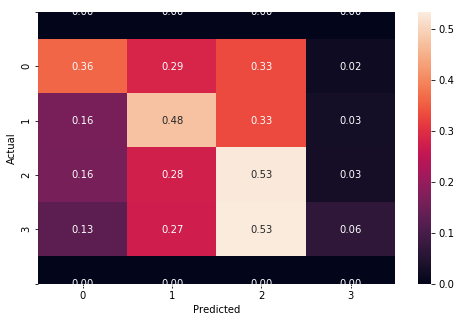

0.41685563114134544


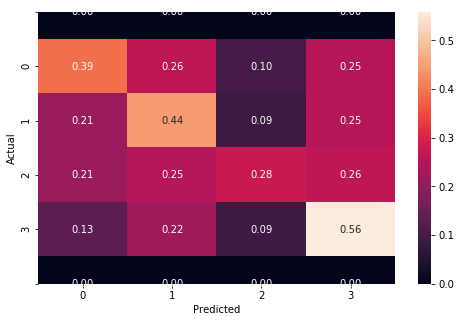

0.4040060468631897


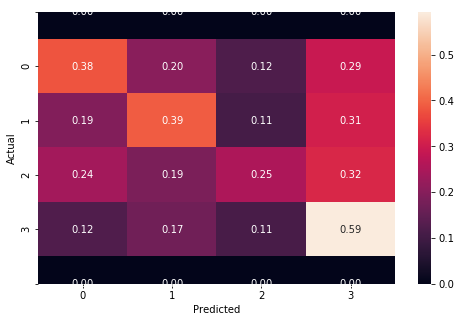

0.34467120181405897


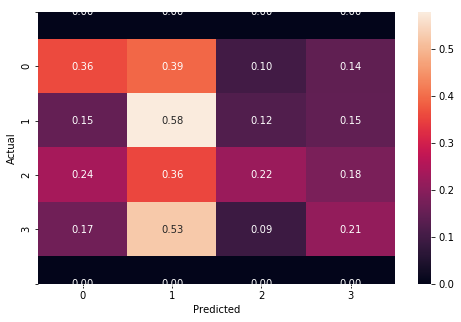

0.36243386243386244


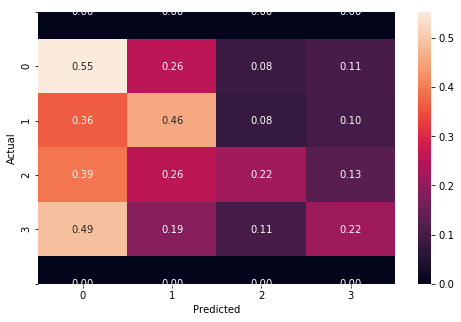

0.3310657596371882


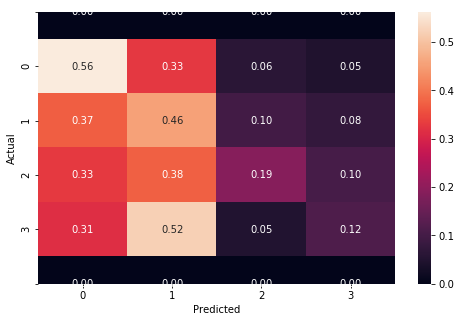

0.39720332577475437


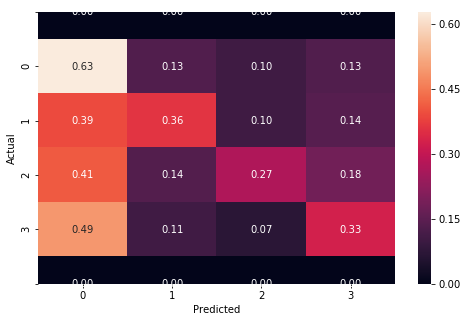

0.36659108087679515


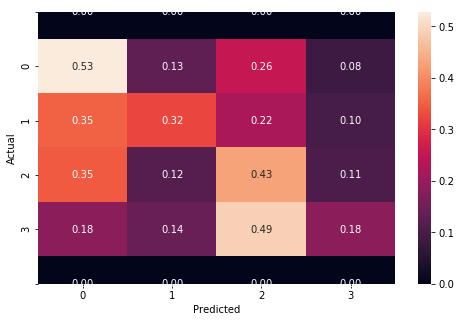

0.3397581254724112


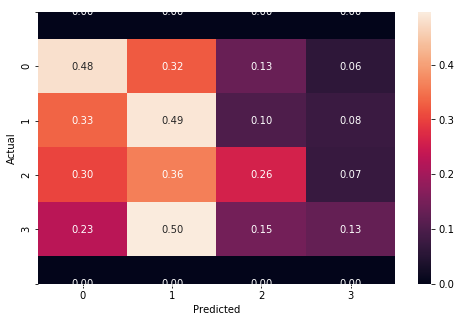

In [17]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.10, random_state=42)
sss.get_n_splits(design.values,target.values)

neigh = KNeighborsClassifier()

parameters={'n_neighbors':[i for i in range(5,10,1)]}
clf=GridSearchCV(neigh,parameters)  
clf.fit(design_s,target_s)
print(clf.best_estimator_.get_params())

for train_index, test_index in sss.split(design_s, target_s):
    X_train, X_test = design_s[train_index], design_s[test_index]
    y_train, y_test = target_s[train_index], target_s[test_index]
  
    clf.best_estimator_.fit(X_train,y_train)
    y_pred=clf.best_estimator_.predict(X_test)
    print('Score: '+clf.best_estimator_.score(X_test,y_test))
    
    conf=confusion_matrix(y_test, y_pred, classes)
    c = conf/conf.astype(np.float).sum(axis=1)[:, np.newaxis]
    dummy_row=np.zeros((len(thresholds[2013])+1,))
    c = np.vstack([dummy_row,c,dummy_row])
    fig, ax = plt.subplots(figsize=(8,5))
    sns.heatmap(c, annot=True, fmt='.2f', xticklabels=classes, yticklabels=['']+classes+[''])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

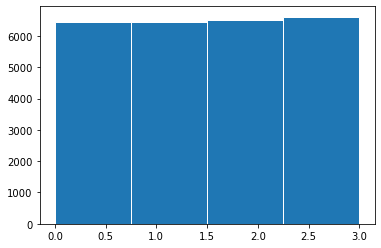

In [18]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)
design_s, target_s = smt.fit_resample(design.values, target.values)

plt.hist(target_s, bins=len(thresholds[2013])+1, edgecolor='white', linewidth=1)
plt.show()

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 18, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 40, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
0.464794151596768


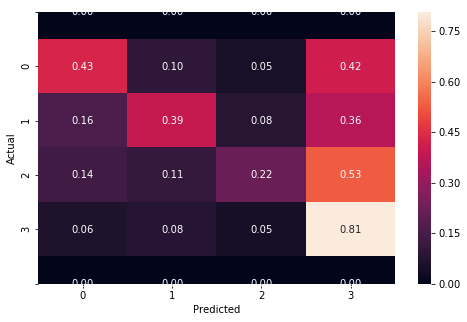

0.45979222777991535


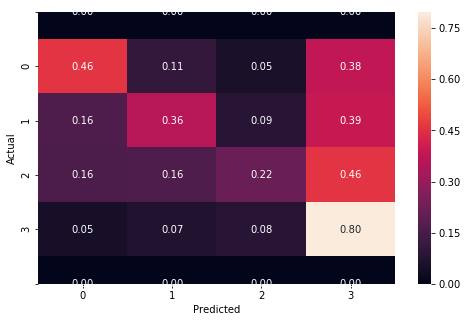

0.47056560215467486


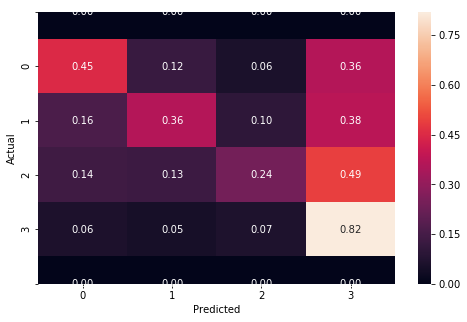

0.467872258560985


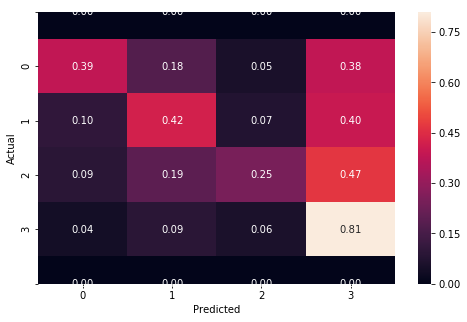

0.4632550981146595


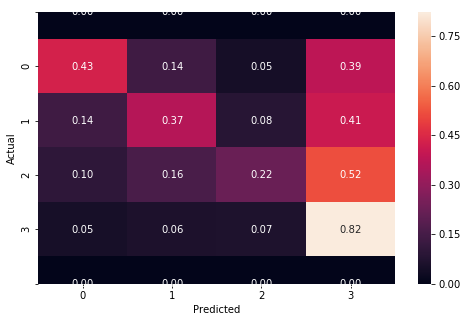

0.46517891496729513


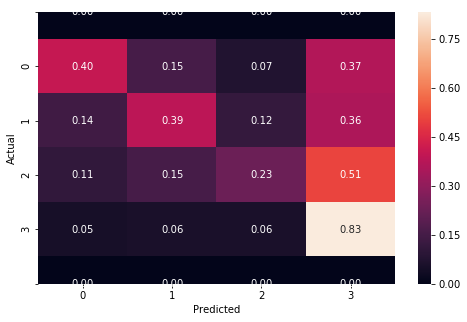

0.4563293574451712


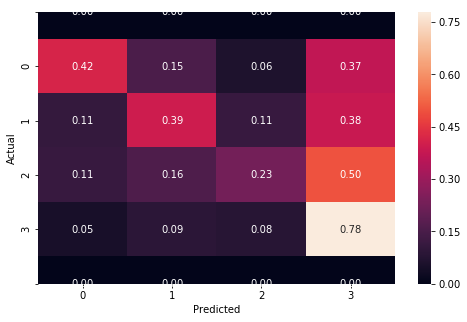

0.4671027318199307


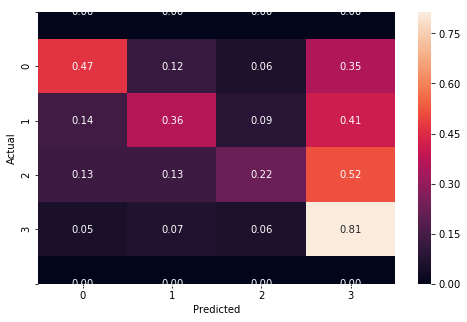

0.47441323585994616


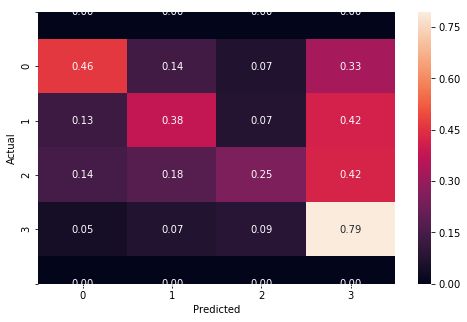

0.46017699115044247


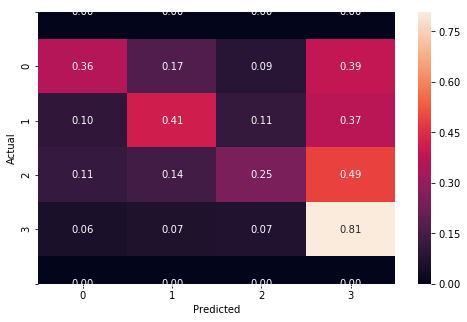

In [19]:
# Random Forest
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.10, random_state=42)
sss.get_n_splits(design.values,target.values)

parameters={'criterion':['gini','entropy'],
            'n_estimators':[i for i in range(10,50,10)],
            'max_depth':[i for i in range(8,20,2)],
            'min_samples_leaf':[i for i in range(5,30,5)]}

rf = RandomForestClassifier(random_state=42)

clf=GridSearchCV(rf,parameters)  
clf.fit(design_s,target_s)
print(clf.best_estimator_.get_params())

for train_index, test_index in sss.split(design_s, target_s):
    X_train, X_test = design_s[train_index], design_s[test_index]
    y_train, y_test = target_s[train_index], target_s[test_index]
    clf.best_estimator_.fit(X_train,y_train)
    y_pred=clf.best_estimator_.predict(X_test)
    print('Score: '+clf.best_estimator_.score(X_test,y_test))
    
    conf=confusion_matrix(y_test, y_pred, classes)
    c = conf/conf.astype(np.float).sum(axis=1)[:, np.newaxis]
    dummy_row=np.zeros((len(thresholds[2013])+1,))
    c = np.vstack([dummy_row,c,dummy_row])
    fig, ax = plt.subplots(figsize=(8,5))
    sns.heatmap(c, annot=True, fmt='.2f', xticklabels=classes, yticklabels=['']+classes+[''])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

{'alpha': 10, 'binarize': 0.0, 'class_prior': None, 'fit_prior': True}
0.35128895729126586


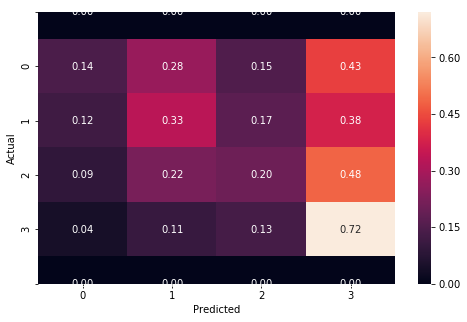

0.3397460561754521


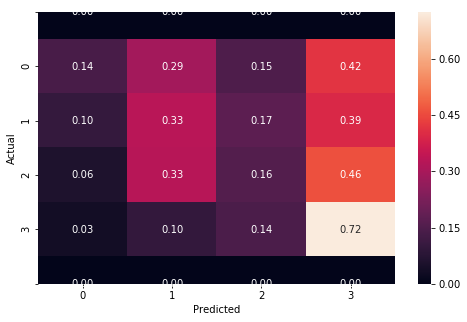

0.35244324740284727


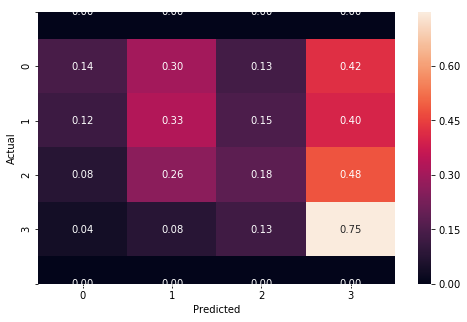

0.3382070026933436


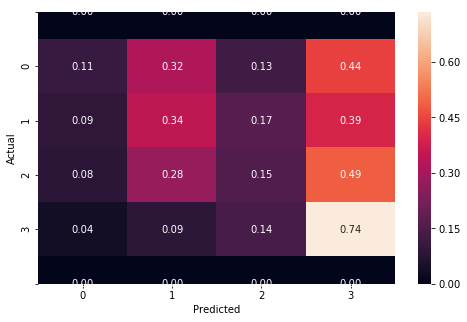

0.34782608695652173


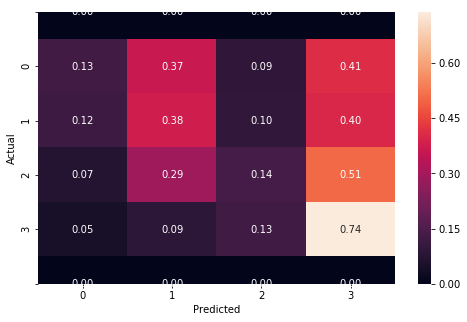

0.35090419392073874


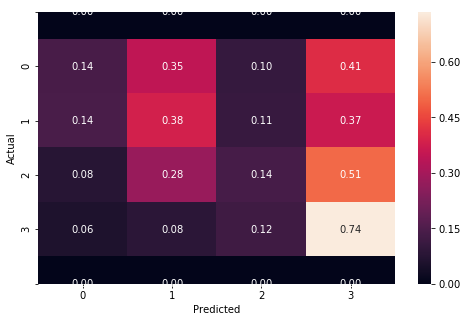

0.3497499038091574


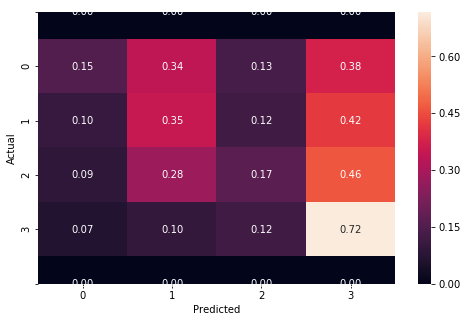

0.33782223932281646


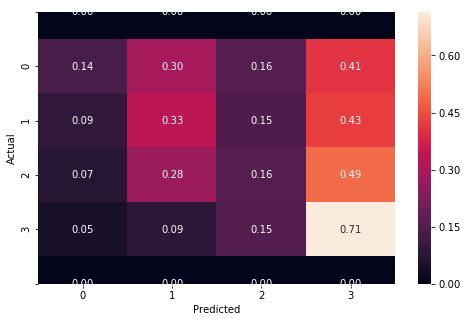

0.3339746056175452


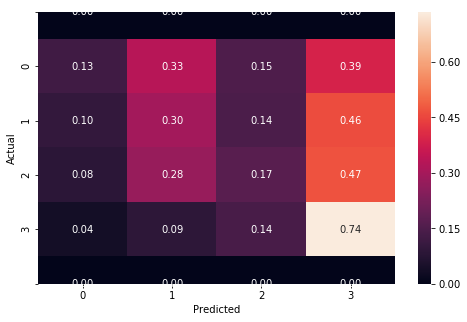

0.3366679492112351


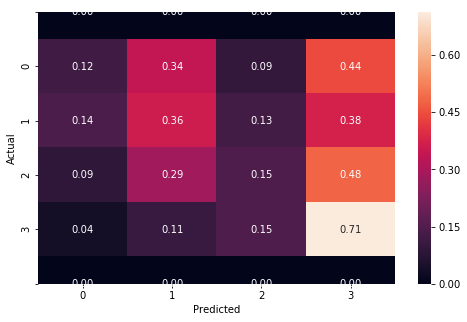

In [20]:
# Naive Bayes
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.10, random_state=42)
sss.get_n_splits(design.values,target.values)

parameters={'alpha':[i for i in range(10,len(design),100)]}
clf=GridSearchCV(bnb,parameters)  
clf.fit(design_s,target_s)
print(clf.best_estimator_.get_params())

for train_index, test_index in sss.split(design_s, target_s):
    X_train, X_test = design_s[train_index], design_s[test_index]
    y_train, y_test = target_s[train_index], target_s[test_index]
  
    clf.best_estimator_.fit(X_train,y_train)
    y_pred=clf.best_estimator_.predict(X_test)
    print('Score: '+clf.best_estimator_.score(X_test,y_test))
    
    conf=confusion_matrix(y_test, y_pred, classes)
    c = conf/conf.astype(np.float).sum(axis=1)[:, np.newaxis]
    dummy_row=np.zeros((len(thresholds[2013])+1,))
    c = np.vstack([dummy_row,c,dummy_row])
    fig, ax = plt.subplots(figsize=(8,5))
    sns.heatmap(c, annot=True, fmt='.2f', xticklabels=classes, yticklabels=['']+classes+[''])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)


{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.39823008849557523


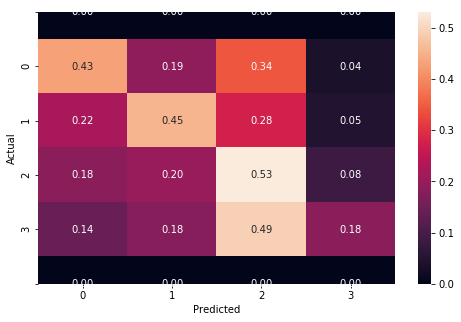

0.4386302424009234


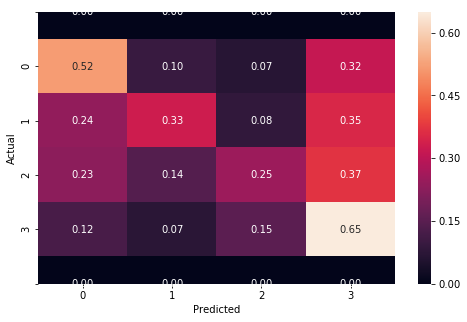

0.4243939976914198


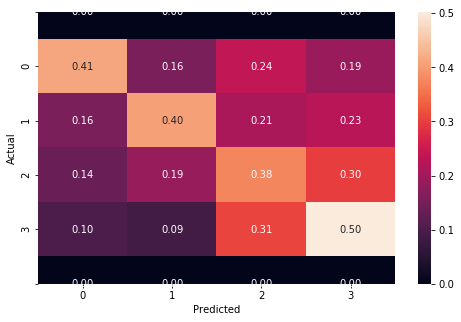

0.40400153905348213


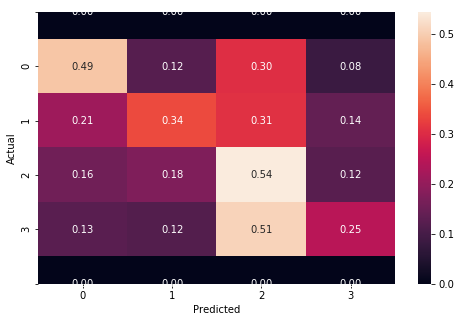

0.37937668333974606


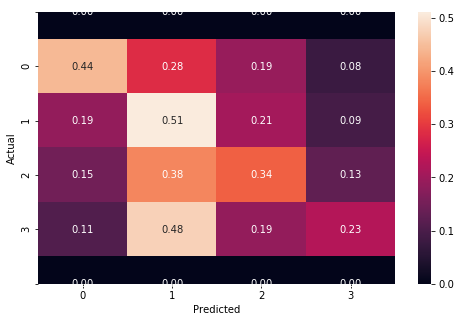

0.4382454790303963


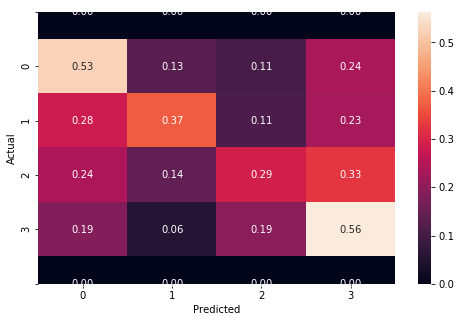

0.3832243170450173


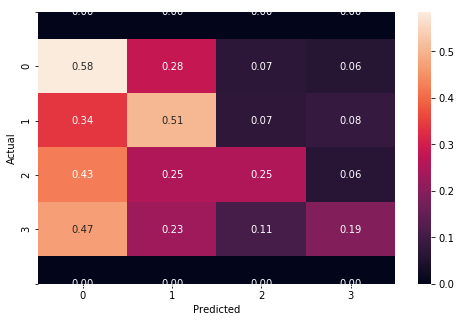

0.43131973836090803


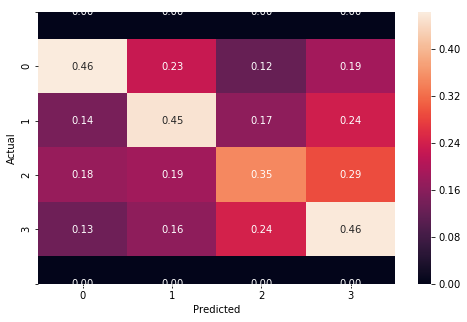

0.425163524432474


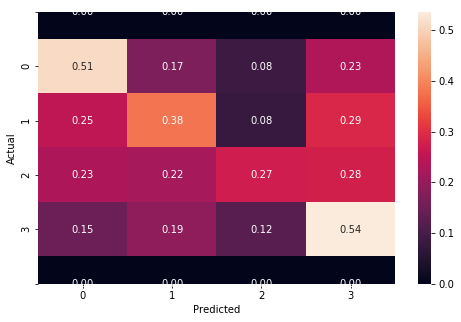

0.38245479030396307


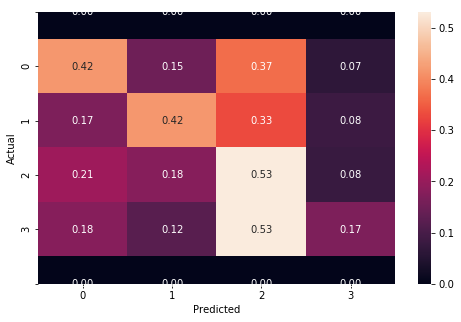

In [21]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.10, random_state=42)
sss.get_n_splits(design.values,target.values)

neigh = KNeighborsClassifier()

parameters={'n_neighbors':[i for i in range(5,10,1)]}
clf=GridSearchCV(neigh,parameters)  
clf.fit(design_s,target_s)
print('Score: '+clf.best_estimator_.get_params())

for train_index, test_index in sss.split(design_s, target_s):
    X_train, X_test = design_s[train_index], design_s[test_index]
    y_train, y_test = target_s[train_index], target_s[test_index]
  
    clf.best_estimator_.fit(X_train,y_train)
    y_pred=clf.best_estimator_.predict(X_test)
    print(clf.best_estimator_.score(X_test,y_test))
    
    conf=confusion_matrix(y_test, y_pred, classes)
    c = conf/conf.astype(np.float).sum(axis=1)[:, np.newaxis]
    dummy_row=np.zeros((len(thresholds[2013])+1,))
    c = np.vstack([dummy_row,c,dummy_row])
    fig, ax = plt.subplots(figsize=(8,5))
    sns.heatmap(c, annot=True, fmt='.2f', xticklabels=classes, yticklabels=['']+classes+[''])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)